<a href="https://colab.research.google.com/github/10100111/Display-of-HW1/blob/main/36_Ultra_pro_%D0%90%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%B8_(%D0%A3%D0%BD%D0%B8%D0%B2%D0%B5%D1%80%D1%81%D0%B8%D1%82%D0%B5%D1%82_%D0%B8%D1%81%D0%BA%D1%83%D1%81%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D0%BE%D0%B3%D0%BE_%D0%B8%D0%BD%D1%82%D0%B5%D0%BB%D0%BB%D0%B5%D0%BA%D1%82%D0%B0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Задание Ultra pro

Макс 10 баллов

Возьмите любую базу картинок (Mnist, Fashion Mnist, Cifar10 или собственную)

На картинках в случайных местах сделайте чёрные квадраты разного размера.

Обучите автокодировщик восстанавливать контент картинок, который скрыт чёрными квадратами

*работать может неидеально

**это не совсем автокодировщик, так как у автокодировщика вход строго равен выходу, но архитектура очень близкая к автокодировщику

#Автокодировщики


In [ ]:
from tensorflow.keras.models import Model, Sequential # загружаем абстрактный класс базовой модели сети от кераса и последовательную модель
# Из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K # подтягиваем базовые керасовские функции
from tensorflow.keras.optimizers import Adam # загружаем выбранный оптимизатор
from tensorflow.keras import utils # загружаем утилиты кераса
from tensorflow.keras.datasets import mnist, fashion_mnist # загружаем готовые базы mnist
from tensorflow.keras.callbacks import LambdaCallback

import matplotlib.pyplot as plt # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
from tensorflow.keras.preprocessing import image # модуль для отрисовки изображения
import numpy as np # библиотека для работы с массивами данных
import pandas as pd # библиотека для анализа и обработки данных
from PIL import Image # модуль для отрисовки изображения
from sklearn.model_selection import train_test_split # модуль для разбивки выборки на тренировочную/тестовую
from sklearn.preprocessing import StandardScaler # модуль для стандартизации данных

import os #
from google.colab import drive #модуль для работы с google диском 
import time, random
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
drive.mount('/content/drive/') # монтируем google диск

Mounted at /content/drive/


In [ ]:
def baseAutoencoder(shape=(112,80,1)): # зададим функцию создания базового автокодировщика
    img_input = Input((shape)) # задаём входные размеры

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) # входные данные передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # затем пропускаем через слой нормализации данных 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # далее снова слой двумерной свёртки
    x = BatchNormalization()(x) # и еще слой нормализации данных
    x = MaxPooling2D()(x) # передаём на слой подвыборки, снижающий размерность поступивших на него данных

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # пропускаем через слой нормализации данных 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)  # далее снова слой двумерной свёртки
    x = BatchNormalization()(x) # и еще слой нормализации данных
    z = MaxPooling2D()(x) # передаём на слой подвыборки
    

    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z) # слой разжимает данные(с 28*20 на 56*40)
    x = BatchNormalization()(x) # слой нормализации данных
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    # Сжатие MaxPooling2D не применяем

    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) # слой разжимает данные(с 56*40 на 112*80)
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных

    # Финальный слой двумерной свертки, выдающий итоговое изображение
    x = Conv2D(shape[-1], (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) # указываем модель, с оригинальным изображением на входе в сеть и сжатым-разжатым на выходе из сети
    model.compile(optimizer=Adam(lr=0.0001),
                  loss='mean_squared_error') # компилируем модель с оптимайзером Адам и среднеквадратичной ошибкой

    return model # функция вернёт заданную модель

In [ ]:
def plotImages(xTrain, pred, shape=(112, 80)): # создадим функцию для вывода изображений как картинок
  n = 5  # количество картинок, которые хотим показать
  plt.figure(figsize=(14, 7)) # указываем размеры фигуры
  for i in range(n): # для каждой картинки из n(5)
      index = np.random.randint(0, pred.shape[0]) # startIndex - начиная с какого индекса хотим заплотить картинки
      # Показываем картинки из тестового набора
      ax = plt.subplot(2, n, i + 1) # выведем область рисования Axes
      plt.imshow(xTrain[index].reshape(shape)) # отрисуем правильные картинки в размере 112*80      
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

      # Показываем восстановленные картинки
      ax = plt.subplot(2, n, i + 1 + n) # выведем область рисования Axes 
      plt.imshow(pred[index].reshape(shape)) # отрисуем обработанные сеткой картинки в размере 112*80     
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y
  plt.show()

In [ ]:
# Функция для расчета mse
def getMSE(x1, x2): # создадим функцию среднеквадратичной ошибки
  x1 = x1.flatten() # сплющиваем в одномерный вектор
  x2 = x2.flatten() # сплющиваем в одномерный вектор
  delta = x1 - x2 # находим разницу
  return sum(delta ** 2) / len(delta) # и возвращаем сумму квадратов разницы, делённую на длину разницы

In [ ]:
# Зададим пару массивов и проверим работу функции
x1 = np.array([1, 1, 1]) # создаем первый массив
x2 = np.array([1, 1, 1]) # создаем второй массив
print(getMSE(x1,x2)) # выведем ошибку полученную нашей функцией

0.0


In [ ]:
# Зададим пару массивов и проверим работу функции
x1 = np.array([1, 1, 1, 1]) # создаем первый массив
x2 = np.array([1, 1, 0, 0]) # создаем второй массив
print(getMSE(x1,x2)) # выведем ошибку полученную нашей функцией

0.5


##Лица

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/MyDrive/Colab Notebooks/Базы/Лица.zip' # распоковываем базу с лицами с google диска в colaboratory

In [ ]:
images_dir = 'Лица' # зададим имя папки в которую распоковали изображения
img_height = 112 # зададим высоту изображений
img_width = 80 # зададим ширину избражений

In [ ]:
# функция загрузки изображений, на вход принемает имя папки с изображениями, высоту и ширину к которой будут преобразованы загружаемые изображения
def load_images(images_dir, img_height, img_width): 
  list_images = [] # создаем пустой список в который будем загружать изображения
  for img in os.listdir(images_dir): # получим список изображений и для каждого изображения
  # добавим в список изображение в виде массива, с заданными размерами, в отенках серого
    list_images.append(image.img_to_array(image.load_img(os.path.join(images_dir, img), target_size=(img_height, img_width), color_mode='grayscale')))
  return np.array(list_images) # возвращаем numpy массив загруженных избражений

In [ ]:
cur_time = time.time() 
xTrain_imag = load_images(images_dir, img_height, img_width) # загрузим избражения лиц
print ('Время загрузки: ', round(time.time()-cur_time, 2), 'с', sep='')

Время загрузки: 31.7с


In [ ]:
xTrain_img = xTrain_imag/255 # отнормируем изображения от 0 до 1

In [ ]:
xTrain_img.shape # выведем размерность массива

(5018, 112, 80, 1)

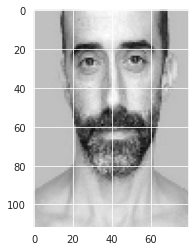

In [ ]:
plt.imshow(xTrain_img[np.random.randint(0, xTrain_img.shape[0])].reshape(112,80), cmap='gray') #выведем случайное изображение
plt.show()

In [ ]:
import cv2
import matplotlib.patches as patches
from PIL import Image, ImageDraw
import random

In [ ]:
img_rect_list = []

for img in xTrain_img:
  i = image.array_to_img(img)
  draw = ImageDraw.Draw(i)
  draw.rectangle((random.randint(0,30), random.randint(0,40), random.randint(0,50), random.randint(0,20)), fill='black')
  img_rect_list.append(image.img_to_array(i))

xTrain_img_rect = np.array(img_rect_list)



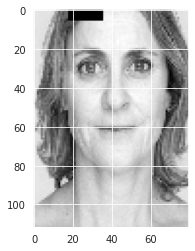

In [ ]:
plt.imshow(xTrain_img_rect[np.random.randint(0,xTrain_img.shape[0])].reshape(img_height, img_width), cmap='gray')

In [ ]:
modelAutoFace = baseAutoencoder() # создаем автокодировщик

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# грузим данные в нашу модель, берём первые 4700 из xTrain_img и на вход, и на выход, в качестве проверочной берем оставшиеся из xTrain_img
modelAutoFace.fit(xTrain_img_rect[:4700], xTrain_img[:4700], epochs=150, batch_size=128, validation_data = (xTrain_img_rect[4700:], xTrain_img[4700:]))

Epoch 1/150
37/37 [==============================] - 15s 143ms/step - loss: 0.0466 - val_loss: 0.0642
Epoch 2/150
37/37 [==============================] - 4s 117ms/step - loss: 0.0170 - val_loss: 0.0546
Epoch 3/150
37/37 [==============================] - 4s 117ms/step - loss: 0.0118 - val_loss: 0.0467
Epoch 4/150
37/37 [==============================] - 4s 117ms/step - loss: 0.0098 - val_loss: 0.0376
Epoch 5/150
37/37 [==============================] - 4s 117ms/step - loss: 0.0084 - val_loss: 0.0273
Epoch 6/150
37/37 [==============================] - 4s 117ms/step - loss: 0.0076 - val_loss: 0.0184
Epoch 7/150
37/37 [==============================] - 4s 117ms/step - loss: 0.0071 - val_loss: 0.0126
Epoch 8/150
37/37 [==============================] - 4s 117ms/step - loss: 0.0068 - val_loss: 0.0096
Epoch 9/150
37/37 [==============================] - 4s 120ms/step - loss: 0.0065 - val_loss: 0.0072
Epoch 10/150
37/37 [==============================] - 4s 118ms/step - loss: 0.0062 - val_l

In [ ]:
modelAutoFace.save_weights('/content/drive/MyDrive/Colab Notebooks/Базы/modelAutoFace.h5') # Сохраняем модель
modelAutoFace.load_weights('/content/drive/MyDrive/Colab Notebooks/Базы/modelAutoFace.h5') # Загружаем модель

In [ ]:
predFace = modelAutoFace.predict(xTrain_img_rect[:100]) # Получаем предсказание модели первых 100 лиц из обучающей выборки
predFace = predFace * 255 # представляем в виде значений от 0 до 255
predFace = predFace.astype('uint8') # устанавливаем 8битовый тип

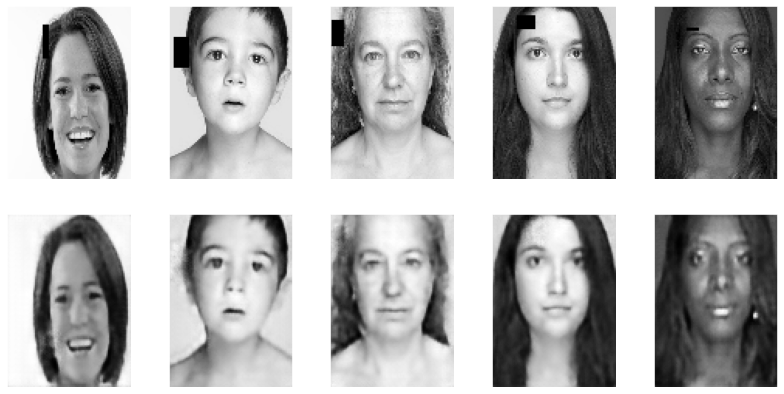

In [ ]:
plotImages(xTrain_img_rect, predFace) #выведем оригинальные и сгенерированные автокодировщиком